# Analisis Kualitas Udara Beijing

## Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set tampilan plotting
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

C:\Users\BOSS\AppData\Local\Temp\ipykernel_25440\1743317983.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Data Loading dan Inspeksi Awal

In [13]:
# Membaca dataset
df = pd.read_csv('dashboard/main_data.csv')

# Memeriksa informasi dataset
print("Info Dataset:")
df.info()

# Menampilkan sample data
print("\nSample Data:")
print(df.head())

# Memeriksa missing values awal
print("\nMissing Values:")
print(df.isnull().sum())

# Memeriksa statistik dasar
print("\nStatistik Dasar:")
print(df.describe())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB

Sample Data:
   No  year  mont

In [14]:
# Hapus kolom No jika ada
if 'No' in df.columns:
    df = df.drop('No', axis=1)

# Simpan kembali
df.to_csv('main_data.csv', index=False)
print("Data berhasil diproses dan disimpan tanpa kolom 'No'")

Data berhasil diproses dan disimpan tanpa kolom 'No'


## 2. Data Preprocessing

In [15]:
# Konversi ke datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Identifikasi kolom numerik untuk preprocessing
numeric_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Penanganan missing values dengan interpolasi
for column in numeric_columns:
    # Interpolasi per stasiun
    for station in df['station'].unique():
        mask = df['station'] == station
        df.loc[mask, column] = df.loc[mask, column].interpolate(method='linear')
    
    # Fill remaining NAs with forward fill
    df[column] = df[column].fillna(method='ffill')
    df[column] = df[column].fillna(method='bfill')

print("Missing Values setelah preprocessing:")
print(df.isnull().sum())

C:\Users\BOSS\AppData\Local\Temp\ipykernel_25440\984354700.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
C:\Users\BOSS\AppData\Local\Temp\ipykernel_25440\984354700.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='bfill')


Missing Values setelah preprocessing:
year           0
month          0
day            0
hour           0
PM2.5          0
PM10           0
SO2            0
NO2            0
CO             0
O3             0
TEMP           0
PRES           0
DEWP           0
RAIN           0
wd          1822
WSPM           0
station        0
datetime       0
dtype: int64


## 3. Feature Engineering

In [16]:
# Tambah kolom temporal
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# Tambah kolom season
df['season'] = pd.cut(df['month'],
                     bins=[0, 3, 6, 9, 12],
                     labels=['Winter', 'Spring', 'Summer', 'Fall'],
                     include_lowest=True)

# Tambah kolom time_of_day
df['time_of_day'] = pd.cut(df['hour'],
                          bins=[-1, 6, 12, 18, 24],
                          labels=['Night', 'Morning', 'Afternoon', 'Evening'])

print("Kolom baru yang ditambahkan:")
print(df.columns.tolist())

Kolom baru yang ditambahkan:
['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime', 'day_of_week', 'is_weekend', 'season', 'time_of_day']


## 4. Penanganan Outlier

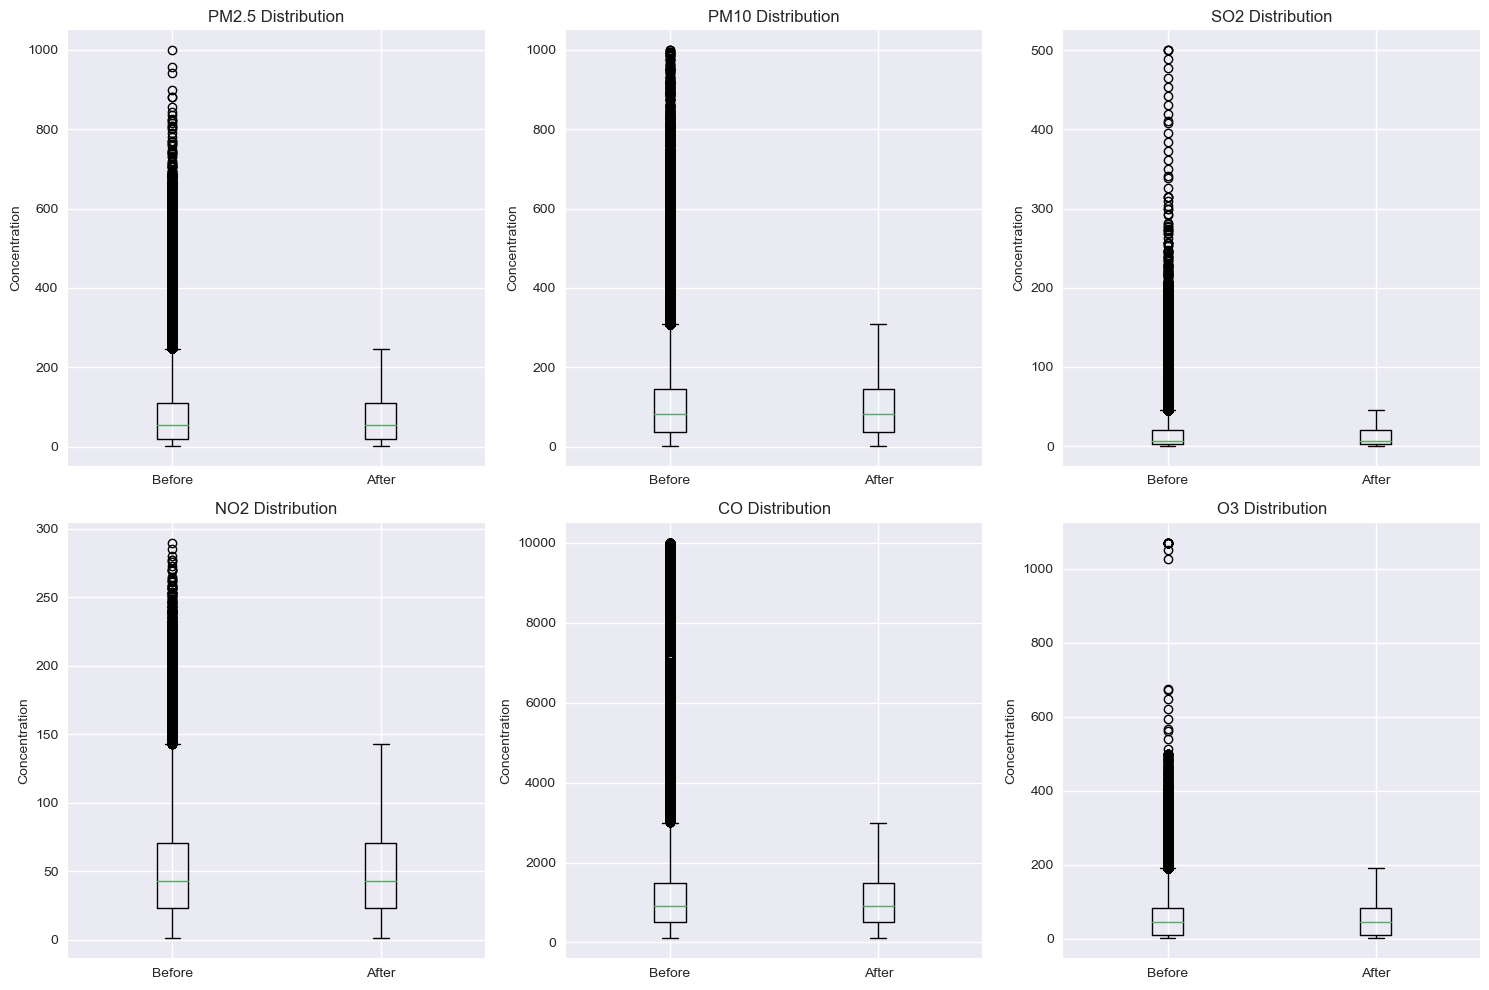


Statistik untuk PM2.5:
count    420768.000000
mean         76.056150
std          68.208418
min           2.000000
25%          20.000000
50%          55.000000
75%         111.000000
max         247.500000
Name: PM2.5, dtype: float64

Statistik untuk PM10:
count    420768.000000
mean        101.463990
std          80.093069
min           2.000000
25%          36.000000
50%          82.000000
75%         145.000000
max         308.500000
Name: PM10, dtype: float64

Statistik untuk SO2:
count    420768.000000
mean         13.529880
std          14.049653
min           0.285600
25%           3.000000
50%           7.000000
75%          20.000000
max          45.500000
Name: SO2, dtype: float64

Statistik untuk NO2:
count    420768.000000
mean         50.200554
std          33.855802
min           1.026500
25%          23.000000
50%          43.000000
75%          71.000000
max         143.000000
Name: NO2, dtype: float64

Statistik untuk CO:
count    420768.000000
mean       1131.529229

In [17]:
def handle_outliers(df, column):
    """Handle outliers menggunakan metode IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# List polutan untuk handling outlier
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

# Plot distribusi sebelum dan sesudah handling outlier
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, pollutant in enumerate(pollutants):
    # Data sebelum handling outlier
    before_data = df[pollutant].copy()
    
    # Handle outliers
    df = handle_outliers(df, pollutant)
    after_data = df[pollutant]
    
    # Create box plot
    data_to_plot = [before_data, after_data]
    labels = ['Before', 'After']
    
    # Plot
    axes[idx].boxplot(data_to_plot, labels=labels)
    axes[idx].set_title(f'{pollutant} Distribution')
    axes[idx].set_ylabel('Concentration')

plt.tight_layout()
plt.show()

# Print statistik sebelum dan sesudah untuk setiap polutan
for pollutant in pollutants:
    print(f"\nStatistik untuk {pollutant}:")
    print(df[pollutant].describe())

## 5. Statistik Dasar

Statistik Deskriptif Polutan:
               PM2.5           PM10            SO2            NO2  \
count  420768.000000  420768.000000  420768.000000  420768.000000   
mean       76.056150     101.463990      13.529880      50.200554   
std        68.208418      80.093069      14.049653      33.855802   
min         2.000000       2.000000       0.285600       1.026500   
25%        20.000000      36.000000       3.000000      23.000000   
50%        55.000000      82.000000       7.000000      43.000000   
75%       111.000000     145.000000      20.000000      71.000000   
max       247.500000     308.500000      45.500000     143.000000   

                  CO             O3  
count  420768.000000  420768.000000  
mean     1131.529229      55.590392  
std       818.445530      51.701952  
min       100.000000       0.214200  
25%       500.000000      10.000000  
50%       900.000000      44.000000  
75%      1500.000000      82.000000  
max      3000.000000     190.000000  

Rata-

C:\Users\BOSS\AppData\Local\Temp\ipykernel_25440\102029574.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_means = df.groupby('season')[pollutants].mean()


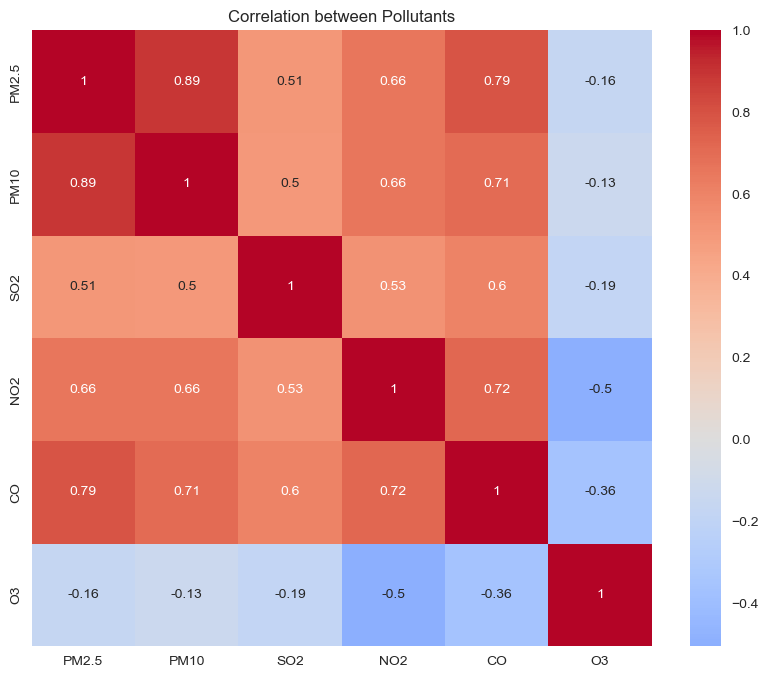

In [18]:
# Statistik deskriptif polutan
print("Statistik Deskriptif Polutan:")
print(df[pollutants].describe())

# Analisis rata-rata per stasiun
station_means = df.groupby('station')[pollutants].mean()
print("\nRata-rata polutan per stasiun:")
print(station_means)

# Analisis rata-rata per musim
season_means = df.groupby('season')[pollutants].mean()
print("\nRata-rata polutan per musim:")
print(season_means)

# Visualisasi korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(df[pollutants].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Pollutants')
plt.show()

## 6. Penyimpanan Data

In [19]:
# Simpan data yang sudah diolah
df.to_csv('dashboard/processed_data.csv', index=False)
print("Data berhasil disimpan ke processed_data.csv")

# Tampilkan informasi akhir dataset
print("\nInformasi final dataset:")
print(f"Total baris: {len(df)}")
print(f"Total kolom: {len(df.columns)}")
print("\nKolom dalam dataset:")
for col in df.columns:
    print(f"- {col}")

Data berhasil disimpan ke processed_data.csv

Informasi final dataset:
Total baris: 420768
Total kolom: 22

Kolom dalam dataset:
- year
- month
- day
- hour
- PM2.5
- PM10
- SO2
- NO2
- CO
- O3
- TEMP
- PRES
- DEWP
- RAIN
- wd
- WSPM
- station
- datetime
- day_of_week
- is_weekend
- season
- time_of_day
